# Projet final du Kit Big Data 2022

Le projet final du Kit Big Data 2022 porte sur les données du **Vendée Globe 2020-2021**.

Le projet se déroule **24 novembre au 4 décembre 2022** date limite pour rendre vos projets respectifs.

Les données du dernier **Vendée Globe** sont disponibles sous la forme de fichiers Excel avec les classements fournis plusieurs fois par jour par les organisateurs de la course. Il y a également une page web avec une fiche technique par voilier qui contient des informations techniques et qu'il est possible de rapprocher des classements.

Il vous appartient de charger les données en Python, de procéder aux préparations nécessaires et d'effectuer les analyses pertinentes de votre choix.

**Sources des données**

- Page web donnant accès aux fichiers Excel des classements du Vendée Globe : https://www.vendeeglobe.org/fr/classement
- Page web avec les fiches techniques des voiliers du Vendée Globe : https://www.vendeeglobe.org/fr/glossaire
- Site web donnant accès à des fichiers avec les formes géométriques des côtes : https://www.naturalearthdata.com/ (ou bien utilisez les librairies **plotly** ou **ipyleaflet** pour produire des cartes)
- etc.

In [199]:
from shutil import copyfileobj
from urllib import request
import uuid
import xlwings as xw
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

## 1. Acquisition et chargement des données :

### 1.1. Mettre en place une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.

Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.

In [200]:
#Téléchargement d'un fichier Excel dans un dossier
def download_excel(url, filename):    
    with request.urlopen(url) as response, open(filename, 'wb') as out_file:
        copyfileobj(response, out_file)
        
# Sauvgarde d'un fichier Excel en mode lisible par pandas avec xlwings
def save_with_xlwings(file, name):
    tempfile = f'./{name}'
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save(tempfile)
    excel_book.close()
    excel_app.quit()
    return tempfile

### 1.2. Acquérir l'ensemble des fichiers Excel des classements via la page de classement.

In [201]:
#Téléchargement des données Excel et sauvgarde dans un format lisible pour pandas
def get_excels(download = False):

    soup = BeautifulSoup(request.urlopen("https://www.vendeeglobe.org/fr/classement/20210305_080000"), 'html.parser')

    file_names = np.unique(np.array([x.get_text() for x in soup.find_all('option')]))[1:-1]

    for i in range(len(file_names)):
        file_names[i] = str(file_names[i]).replace("-","").replace(" ", "").replace(":","")
        file_names[i] = file_names[i][:8]+"_"+file_names[i][8:]+".xlsx"

        url = "https://www.vendeeglobe.org/download-race-data/vendeeglobe_"+file_names[i]

        if download:
            download_excel(url, "Excel_files/"+file_names[i])
            save_with_xlwings("Excel_files/"+file_names[i], "Excel_files/Readable_excel/"+file_names[i])
            print(len(file_names)," files retirved")
    print(len(file_names), "files loaded from local directory") 
    return file_names

#get_excels()

### 1.3. Acquérir les caractéristiques des bateaux.

In [202]:
#Récupération des données des voiliers
def get_stats_voiliers():

    soup = BeautifulSoup(request.urlopen("https://www.vendeeglobe.org/fr/glossaire").read(), "lxml")

    div_specs = soup.findAll('div', attrs={'class': 'boats-list__popup mfp-hide'})
    div_boat_info = soup.findAll('div', attrs={'class': 'boats-list__infos'})
    
    boat_skipper = []
    for tags in div_boat_info:
        boatname = tags.find('h3', 'boats-list__boat-name').text.upper()
        skippername = tags.find('span', 'boats-list__skipper-name').text.upper()
        boat_skipper.append((boatname, skippername))

    result = []
    for i, tags in enumerate(div_specs):
        ul = tags.findAll('ul', attrs={"ul", "boats-list__popup-specs-list"})

        for specs in ul:
            pattern = re.compile('(.*):(.*)')
            matches = pattern.findall(specs.text)

            tmp = {}
            for pair in matches:
                key = pair[0].strip()
                value = pair[1].strip()
                tmp["Bateau"] = boat_skipper[i][0]
                tmp['Skipper'] = boat_skipper[i][1]
                tmp[key] = value

            result.append(tmp)
    print("boat data retrived from the web")
    return pd.DataFrame(result)

#get_stats_voiliers()

## 2. Préparation des données

### 2.1. Extraction des caractéristiques techniques de chacun des voiliers.

In [203]:
def convert_to_float(distance):
    distance = distance.replace(" ", "")
    distance = distance.replace(",", ".")
    return float(distance[:-1])

In [204]:
def convert_foils(nb):
    nb = nb.replace('foils', '0')
    nb = nb.replace(' ', '')
    nb = nb.replace('asymétriques', '')
    nb = nb.replace('foiler', '0')
    return int(nb)

In [205]:
def correct_voiliers(df):
    column_to_drop = 'Chantier : CDK Technologies / Assemblage'

    if column_to_drop in df.columns:
        df = df.drop(column_to_drop, axis=1)

    df = df.drop(df.loc[df["Bateau"]==""].index)
    df['Bateau'] = df['Bateau'].apply(lambda row: row.strip())
    columns_to_convert = ['Hauteur mât', 'Longueur', 'Largeur', 'Tirant d\'eau']

    for column in columns_to_convert:
        df[column] = df[column].apply(lambda row: convert_to_float(row))

    columns_to_convert = ['Surface de voiles au près', 'Surface de voiles au portant']

    for column in columns_to_convert:
        df[column] = df[column].apply(lambda row: float(row[:-2]))

    df['Nombre de dérives'] = df['Nombre de dérives'].apply(lambda row: convert_foils(row))
    df['Dérive / Foil'] = df['Nombre de dérives'].apply(lambda row: 0 if row > 0 else 1)
    df = df.drop('Nombre de dérives', axis = 1)

        
    incorrect_spelling = ['YES WE CAM!', 'V AND B-MAYENNE', 'PURE - BEST WESTERN®', 'COMPAGNIE DU LIT / JILITI', 'NEWREST - ART & FENÊTRES', 'BUREAU VALLEE 2', 'INITIATIVES-COEUR', 'CORUM L\'EPARGNE']
    correct_spelling = ['YES WE CAM !', 'V AND B MAYENNE', 'PURE - BEST WESTERN HOTELS AND RESORTS', 'COMPAGNIE DU LIT - JILITI', 'NEWREST - ART ET FENETRES', 'BUREAU VALLÉE 2','INITIATIVES - COEUR', 'CORUM L\'ÉPARGNE']
    
    df.at[2, 'Bateau'] = 'TSE - 4MYPLANET'
    df.at[11, 'Skipper'] = 'Samantha Davies'
    df.at[25, 'Skipper'] = 'Alan Roura'
    df.at[5, 'Skipper'] = 'Arnaud Boissieres'

    for i in range(len(incorrect_spelling)):
        index = df.loc[df['Bateau']==incorrect_spelling[i]].index[0]
        df.at[index, 'Bateau'] = correct_spelling[i]

    df['Skipper'] = df['Skipper'].apply(lambda row: row.title())
    
    incorrect_spelling = ['FRA72', '17', '08', '18', 'FRA30', 'FRA109', '69', 'FRA09', 'FRA83', 'GBR77', '16', 'FIN222', '001', 'FRA50', 'SUI07', '2', 'FRA53', 'FRA1000', '4']
    correct_spelling = ['FRA 72', 'FRA 17', 'FRA 8', 'FRA 18', 'FRA 30', 'FRA 109', 'FRA 69', 'FRA 09', 'FRA 83', 'GBR 777', 'MON 10', 'FIN 222', 'FRA 01', 'FRA 50', 'SUI 7', 'FRA 02', 'FRA 53', 'FRA 1000', 'FRA 4']

    for i in range(len(incorrect_spelling)):
        index = df.loc[df['Numéro de voile']==incorrect_spelling[i]].index[0]
        df.at[index, 'Numéro de voile'] = correct_spelling[i]
    
    index = df.loc[df['Numéro de voile'].isna()].index[0]
    df.at[index, 'Numéro de voile'] = 'FRA 59'
    
    df = df.drop(['Anciens noms du bateau', 'Chantier', 'Voile quille', 'Architecte'], axis = 1)
    print("boat data cleaned and exploitable")
    return df

#correct_voiliers(get_stats_voiliers())

In [206]:
def load_files(file_names):
    course_data = []
    col_names=['Rang', 'Voile', 'Skipper_Bateau', 'Heure FR', 'Lattitude', 'Longitude', 'Cap (°)', 'Vitesse (kts)', 'VMG (kts)', 'Distance (nm)', 'Cap (°)', 'Vitesse (kts)', 'VMG (kts)', 'Distance (nm)', 'Cap (°)','Vitesse (kts)', 'VMG (kts)', 'Distance (nm)','DTF (nm)', 'DTL (nm)']
    for i in range(len(file_names[:-222])):
        course_data.append(pd.read_excel("Excel_files/Readable_excel/"+file_names[i], usecols="B:U", nrows=36, skiprows=1, names=col_names))
    print(len(file_names[:-222]),"files transfer into data frame")
    return course_data

#file_names=get_excels()
#course_data=load_files(file_names)

In [207]:
#course_data[1]

### 2.2. Préparation des données relatives aux classements.

In [208]:
def floatisation(ligne):
    if ligne == "RET" or ligne == "NL":
        return 1000.0
    elif pd.isna(ligne):
        pass
    else:
        try:
            ligne = float(ligne)
        except ValueError:
            pass
        return ligne

In [209]:
def pre_processing(course_data):
    for i in range(len(course_data)):
        df = course_data[i]
        
        df.insert(2, 'Skipper', df.Skipper_Bateau.str.split("\n",expand=True,)[0])
        df.insert(3, 'Bateau', df.Skipper_Bateau.str.split("\n",expand=True,)[1])
        df = df.drop('Skipper_Bateau', axis=1)
        
        df["Rang"] = df["Rang"].apply(lambda row: floatisation(row))
        
        df["Voile"] = df["Voile"].str.replace("\n","").replace(" ","")
        df["Heure FR"] = df["Heure FR"].str.replace(" FR\n","")
        
        df["Cap (°)"] = df["Cap (°)"].str.replace("°","").apply(lambda row: floatisation(row))
        df["Vitesse (kts)"] = df["Vitesse (kts)"].str.replace(" kts","").apply(lambda row: floatisation(row))
        df["VMG (kts)"] = df["VMG (kts)"].str.replace(" kts","").apply(lambda row: floatisation(row))
        df["Distance (nm)"] = df["Distance (nm)"].str.replace(" nm","").apply(lambda row: floatisation(row))
        
        df["Cap (°).1"] = df["Cap (°).1"].str.replace("°","").apply(lambda row: floatisation(row))
        df["Vitesse (kts).1"] = df["Vitesse (kts).1"].str.replace(" kts","").apply(lambda row: floatisation(row))
        df["VMG (kts).1"] = df["VMG (kts).1"].str.replace(" kts","").apply(lambda row: floatisation(row))
        df["Distance (nm).1"] = df["Distance (nm).1"].str.replace(" nm","").apply(lambda row: floatisation(row))
        
        df["Cap (°).2"] = df["Cap (°).2"].str.replace("°","").apply(lambda row: floatisation(row))
        df["Vitesse (kts).2"] = df["Vitesse (kts).2"].str.replace(" kts","").apply(lambda row: floatisation(row))
        df["VMG (kts).2"] = df["VMG (kts).2"].str.replace(" kts","").apply(lambda row: floatisation(row))
        df["Distance (nm).2"] = df["Distance (nm).2"].str.replace(" nm","").apply(lambda row: floatisation(row))
        
        df["DTF (nm)"] = df["DTF (nm)"].str.replace(" nm","").apply(lambda row: floatisation(row))
        df["DTL (nm)"] = df["DTL (nm)"].str.replace(" nm","").apply(lambda row: floatisation(row))
        
        course_data[i] = df
    print("pre-processing done on", len(course_data), "dataframe")
    return course_data

#file_names=get_excels()
#course_data=load_files(file_names)
#course_data=pre_processing(course_data)

In [210]:
#course_data[1][3:]

### 2.3. Rapprochement des données des voiliers avec celle des classements.

Au lieu de faire un merge entre les tableaux, il semble plus judicieux de construire un grande structure de donnée.  

Celle-ci prendra la forme de dictionnaires imbriquées. Bien sur, c'est simplement une maière d'aranger les données et on travail toujours avec des DataFrame en utilisant pandas. La raison pour laquelle j'ai réalisé cette structure c'est parce que je pense qu'elle est plus adpaté a manipuler que de mettre toutes les données dans un seul gros tableau.

Elle va donc contenir toutes les informations dont on a besoin mais en réduisant grandement la complexité d'accès aux données, voici donc la structre : 

struct Voiliers  

&emsp;- nom skipper  
&emsp;&emsp;- Louis Burton  
&emsp;&emsp;- Boris Herrmann  
&emsp;&emsp;- ... (suite des noms)  

&emsp;- dates du classement  
&emsp;&emsp;- dimanche 08 novembre 2020 à 16h00  
&emsp;&emsp;- dimanche 08 novembre 2020 à 17h00  
&emsp;&emsp;- ... (suite des classements) 

&emsp;- caracteristiques voiliers  
&emsp;&emsp;- Bateau   
&emsp;&emsp;- Skipper   
&emsp;&emsp;- ... (suite des caractéristiques) 

&emsp;- données course  
&emsp;&emsp;- Louis Burton  
&emsp;&emsp;&emsp;- dimanche 08 novembre 2020 à 16h00  
&emsp;&emsp;&emsp;&emsp;- données skipper  
&emsp;&emsp;&emsp;&emsp;&emsp;- Rang  
&emsp;&emsp;&emsp;&emsp;&emsp;- Voile  
&emsp;&emsp;&emsp;&emsp;&emsp;- Skipper+equipe  
&emsp;&emsp;&emsp;&emsp;&emsp;- Heure  
&emsp;&emsp;&emsp;&emsp;&emsp;- Lattitude  
&emsp;&emsp;&emsp;&emsp;&emsp;- Longitude  
&emsp;&emsp;&emsp;&emsp;&emsp;- DTF  
&emsp;&emsp;&emsp;&emsp;&emsp;- DTL  
&emsp;&emsp;&emsp;&emsp;- données depuis 30 min  
&emsp;&emsp;&emsp;&emsp;&emsp;- Cap  
&emsp;&emsp;&emsp;&emsp;&emsp;- Vitesse  
&emsp;&emsp;&emsp;&emsp;&emsp;- VMG  
&emsp;&emsp;&emsp;&emsp;&emsp;- Distance  
&emsp;&emsp;&emsp;&emsp;- données depuis dernier classement  
&emsp;&emsp;&emsp;&emsp;&emsp;- Cap  
&emsp;&emsp;&emsp;&emsp;&emsp;- Vitesse  
&emsp;&emsp;&emsp;&emsp;&emsp;- VMG  
&emsp;&emsp;&emsp;&emsp;&emsp;- Distance  
&emsp;&emsp;&emsp;&emsp; - données depuis 24h  
&emsp;&emsp;&emsp;&emsp;&emsp;- Cap  
&emsp;&emsp;&emsp;&emsp;&emsp;- Vitesse  
&emsp;&emsp;&emsp;&emsp;&emsp;- VMG  
&emsp;&emsp;&emsp;&emsp;&emsp;- Distance  

&emsp;&emsp;&emsp;- dimanche 08 novembre 2020 à 17h00  
&emsp;&emsp;&emsp;&emsp;- ... (suite des données)  
&emsp;&emsp;&emsp;- ... (suite des dates) 

&emsp;&emsp;- Boris Herrmann  
&emsp;&emsp;&emsp;- dimanche 08 novembre 2020 à 16h00  
&emsp;&emsp;&emsp;&emsp;- données skipper  
&emsp;&emsp;&emsp;&emsp;&emsp; - ... (données)  
&emsp;&emsp;&emsp;&emsp;- données depuis 30 min  
&emsp;&emsp;&emsp;&emsp;&emsp;- ... (données)  
&emsp;&emsp;&emsp;&emsp;- données depuis dernier classement  
&emsp;&emsp;&emsp;&emsp;&emsp;- ... (données)  
&emsp;&emsp;&emsp;&emsp;- données depuis 24h  
&emsp;&emsp;&emsp;&emsp;&emsp;- ... (données)  

&emsp;&emsp;&emsp;- dimanche 08 novembre 2020 à 17h00  
&emsp;&emsp;&emsp;&emsp;- ...  (suite des données)  

&emsp;&emsp;&emsp;- ...  (suite des dates) 

&emsp;&emsp;- ...  (suite des noms)  
    

In [211]:
def get_data_for_skipper(skipper, classement):
    for i, data in enumerate(classement["Skipper"][3:]):
        if skipper in data:
            return classement.iloc[i+3][:7], classement.iloc[i+3][7:11], classement.iloc[i+3][11:15], classement.iloc[i+3][15:19], pd.to_numeric(classement.iloc[i+3][19:21])
        
#skipper_data, trente_minutes, dernier_classement, vingt_quatre, other_data =  get_data_for_skipper("Louis Burton", course_data[1])

In [212]:
#pd.concat([skipper_data,other_data])

In [213]:
#dernier_classement

In [214]:
def get_dates_course(course_data):
    list_dates = []
    for i in range(len(course_data)):
        list_dates.append(course_data[i].iloc[0,0][14:-3])
    return list_dates

#get_dates_course(course_data)

In [215]:
#Construction de la structure de données décrite plus haut
def build_data_structure(course_data):
    #initialisation de la structure de donnée
    voiliers = {}
    
    #Construction de la liste des noms des skipper
    voiliers["nom skipper"] = list(course_data[0]["Skipper"][3:])
    
    #Contruction des caractéristiques des voiliers
    voiliers["caracteristiques voiliers"] = correct_voiliers(get_stats_voiliers())
    
    #Construction de la listes des dates
    voiliers["dates du classement"] = get_dates_course(course_data)
    
    #Construction des données de la course
    voiliers["données course"] = {}
    
    for skipper in voiliers["nom skipper"]:
        voiliers["données course"][skipper] = {}
        
        for classement in course_data:
            #initialisation des éléments des données de la course pour un classement
            date = classement.iloc[0,0][14:-3]
            voiliers["données course"][skipper][date] = {}
            
            #Récuperation des données pour un skipper sur ce classmeent
            skipper_data, trente_minutes, dernier_classement, vingt_quatre, other_data =  get_data_for_skipper(skipper, classement)
            
            #Remplissage des informations du skipper pour ce classement dans la structure de donnée
            voiliers["données course"][skipper][date]["données skipper"] = pd.concat([skipper_data,other_data])
            voiliers["données course"][skipper][date]["données depuis 30 min"] = pd.to_numeric(trente_minutes)
            voiliers["données course"][skipper][date]["données depuis dernier classement"] = pd.to_numeric(dernier_classement)
            voiliers["données course"][skipper][date]["données depuis 24h"] = pd.to_numeric(vingt_quatre)
    print("data successfully deployed in the structure")
    print("data ready to be exploited")
    return voiliers

### 2.4. Lancement du programme de récupération des données

Maintenant que toutes les fonctions nécessaires a l'acquisition des données ont été écrite, on va pouvoir les lancer

In [216]:
#On lance donc toutes les fonctions du programme

file_names = get_excels()
course_data = load_files(file_names)
course_data = pre_processing(course_data)
voiliers = build_data_structure(course_data)

702 files loaded from local directory
480 files transfer into data frame
pre-processing done on 480 dataframe
boat data retrived from the web
boat data cleaned and exploitable
data successfully deployed in the structure
data ready to be exploited


#### On vérifie qu'on a bien récupéré toutes les informations contenus dans les excels du classements et les infos des voiliers

In [217]:
voiliers["nom skipper"]

['Louis Burton',
 'Boris Herrmann',
 'Jérémie Beyou',
 'Thomas Ruyant',
 'Maxime Sorel',
 'Fabrice Amedeo',
 'Jean Le Cam',
 'Alex Thomson',
 'Sébastien Destremau',
 'Pip Hare',
 'Kevin Escoffier',
 'Stéphane Le Diraison',
 'Romain Attanasio',
 'Damien Seguin',
 'Clément Giraud',
 'Samantha Davies',
 'Yannick Bestaven',
 'Giancarlo Pedote',
 'Kojiro Shiraishi',
 'Nicolas Troussel',
 'Manuel Cousin',
 'Clarisse Cremer',
 'Alan Roura',
 'Didac Costa',
 'Benjamin Dutreux',
 'Armel Tripon',
 'Alexia Barrier',
 'Isabelle Joschke',
 'Sébastien Simon',
 'Miranda Merron',
 'Ari Huusela',
 'Charlie Dalin',
 'Arnaud Boissieres']

In [218]:
voiliers["dates du classement"]

['dimanche 08 novembre 2020 à 16h00',
 'dimanche 08 novembre 2020 à 17h00',
 'dimanche 08 novembre 2020 à 19h00',
 'dimanche 08 novembre 2020 à 23h00',
 'lundi 09 novembre 2020 à 06h00',
 'lundi 09 novembre 2020 à 10h00',
 'lundi 09 novembre 2020 à 13h00',
 'lundi 09 novembre 2020 à 16h00',
 'lundi 09 novembre 2020 à 19h00',
 'lundi 09 novembre 2020 à 23h00',
 'mardi 10 novembre 2020 à 06h00',
 'mardi 10 novembre 2020 à 10h00',
 'mardi 10 novembre 2020 à 13h00',
 'mardi 10 novembre 2020 à 16h00',
 'mardi 10 novembre 2020 à 19h00',
 'mardi 10 novembre 2020 à 23h00',
 'mercredi 11 novembre 2020 à 06h00',
 'mercredi 11 novembre 2020 à 10h00',
 'mercredi 11 novembre 2020 à 13h00',
 'mercredi 11 novembre 2020 à 16h00',
 'mercredi 11 novembre 2020 à 19h00',
 'mercredi 11 novembre 2020 à 23h00',
 'jeudi 12 novembre 2020 à 06h00',
 'jeudi 12 novembre 2020 à 10h00',
 'jeudi 12 novembre 2020 à 13h00',
 'jeudi 12 novembre 2020 à 16h00',
 'jeudi 12 novembre 2020 à 19h00',
 'jeudi 12 novembre 2020 

In [219]:
voiliers["caracteristiques voiliers"]

,Bateau,Skipper,Numéro de voile,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Dérive / Foil
0,NEWREST - ART ET FENETRES,Fabrice Amedeo,FRA 56,01 Août 2015,18.28,5.85,4.5,7 t,29.0,320.0,570.0,1
1,PURE - BEST WESTERN HOTELS AND RESORTS,Romain Attanasio,FRA 49,08 Mars 2007,18.28,5.80,4.5,9t,28.0,280.0,560.0,0
2,TSE - 4MYPLANET,Alexia Barrier,FRA 72,01 Mars 1998,18.28,5.54,4.5,9t,29.0,260.0,580.0,0
3,MAÎTRE COQ IV,Yannick Bestaven,FRA 17,12 Mars 2015,18.28,5.80,4.5,8 t,29.0,310.0,550.0,1
4,CHARAL,Jérémie Beyou,FRA 8,18 Août 2018,18.28,5.85,4.5,8t,29.0,320.0,600.0,1
5,LA MIE CÂLINE - ARTISANS ARTIPÔLE,Arnaud Boissieres,FRA 14,03 Août 2007,18.28,5.65,4.5,"7,9 tonnes",29.0,300.0,610.0,1
6,BUREAU VALLÉE 2,Louis Burton,FRA 18,09 Juin 2015,18.28,5.80,4.5,"7,6 t",28.0,300.0,600.0,1
7,ONE PLANET ONE OCEAN,Didac Costa,ESP 33,02 Février 2000,18.28,5.30,4.5,"8,9 t",26.0,240.0,470.0,0
8,GROUPE SÉTIN,Manuel Cousin,FRA 71,02 Février 2007,18.28,5.80,4.5,9 t,28.5,270.0,560.0,0
9,BANQUE POPULAIRE X,Clarisse Cremer,FRA 30,01 Mars 2011,18.28,5.70,4.5,"7,7 t",29.0,340.0,570.0,0


In [220]:
voiliers["données course"]["Louis Burton"]["dimanche 08 novembre 2020 à 16h00"]["données skipper"]

Rang                     1.0
Voile                 FRA 18
Skipper         Louis Burton
Bateau       Bureau Vallée 2
Heure FR               15:30
Lattitude         46°24.46'N
Longitude         01°50.48'W
DTF (nm)             24293.9
DTL (nm)                 0.0
Name: 3, dtype: object

In [221]:
voiliers["données course"]["Louis Burton"]["dimanche 08 novembre 2020 à 16h00"]["données depuis 30 min"]

Cap (°)          241.0
Vitesse (kts)     17.7
VMG (kts)         17.5
Distance (nm)      0.3
Name: 3, dtype: float64

#### Il ne manque plus qu'as écrire des petites fonctions, permettant de re-concentrer les données distribuées dans la structure.

In [222]:
#fonction pour récupérer les données d'évolution d'un skipper sur l'ensemble de la course
def get_info_course_skipper(voiliers, skipper, temps):

    info_skipper = []
    for date in voiliers["dates du classement"]:
        info_skipper.append(voiliers["données course"][skipper][date][temps])
    return pd.DataFrame(info_skipper)

get_info_course_skipper(voiliers, "Louis Burton", "données depuis 30 min")

,Cap (°),Vitesse (kts),VMG (kts),Distance (nm)
3,241.0,17.7,17.5,0.3
10,269.0,20.9,18.0,10.5
13,271.0,20.3,16.4,10.2
10,262.0,12.3,10.1,6.2
13,294.0,13.9,0.4,6.9
...,...,...,...,...
5,2.0,16.6,0.8,8.3
5,82.0,18.3,18.1,9.2
5,104.0,16.2,15.9,8.1
5,99.0,17.9,17.7,8.9


## 3. Analyses et story telling

On va maintenant utiliser toutes les petites fonctions qui permettent de récupérer les données dont a besoin depuis la structure de donnée pour faire quelques petites déductions intéressantes.

### 3.1. Corrélation entre le classement (rang) et la vitesse utile (VMG) des voiliers.

In [223]:
#fonction qui récupére les valeurs de VMG en fonction du classement
def get_Rank_and_VMG(voiliers):
    VMG_30min, VMG_dernier_classement, VMG_24h, Rang = [], [], [], []
    for skipper in voiliers["nom skipper"]:
        
        VMG_30min.append(pd.to_numeric(get_info_course_skipper(voiliers, skipper, "données depuis 30 min")["VMG (kts)"]).mean())
        VMG_dernier_classement.append(pd.to_numeric(get_info_course_skipper(voiliers, skipper, "données depuis dernier classement")["VMG (kts).1"]).mean())
        VMG_24h.append(pd.to_numeric(get_info_course_skipper(voiliers, skipper, "données depuis 24h")["VMG (kts).2"]).mean())
        
        Rang.append(pd.to_numeric(get_info_course_skipper(voiliers, skipper, "données skipper")["Rang"]).mean())
    
    VMG = pd.concat([pd.DataFrame(VMG_30min),pd.DataFrame(VMG_dernier_classement),pd.DataFrame(VMG_24h)],axis=1)
        
    return VMG,pd.DataFrame(Rang)

#VMG,Rang = get_Rank_and_VMG_dernier_classement(voiliers)

In [224]:
VMG, Rang = get_Rank_and_VMG(voiliers)
corr = np.array(VMG.corrwith(Rang))

print("la corrélation entre le rang et la vitesse utile (VMG) depuis 30 min est de : ", round(corr[0],3))
print("la corrélation entre le rang et la vitesse utile (VMG) depuis le dernier classement est de : ", round(corr[1],3))
print("la corrélation entre le rang et la vitesse utile (VMG) depuis 24h est de : ", round(corr[2],3))

la corrélation entre le rang et la vitesse utile (VMG) depuis 30 min est de :  -0.254
la corrélation entre le rang et la vitesse utile (VMG) depuis le dernier classement est de :  -0.269
la corrélation entre le rang et la vitesse utile (VMG) depuis 24h est de :  -0.27


### 3.2. Régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

In [225]:
VMG, Rang = get_Rank_and_VMG(voiliers)
df = pd.concat([VMG.iloc[:,1], Rang], axis=1).dropna()

df

,0,0
0,12.813750,6.839583
1,12.788125,6.956250
2,11.319375,22.404167
3,12.640208,3.518750
4,12.280208,10.681250
5,8.581000,594.568750
6,12.478333,5.589583
7,11.120513,677.425000
8,7.946283,155.464583
9,10.903750,19.227083


In [226]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.4, random_state=25)

reg = LinearRegression().fit(X_train, y_train)
print(f"résultats du modèle :\n\t- coefficients: {reg.coef_[0]}\n\t- intercept: {reg.intercept_}\n\t- R2: {reg.score(X_test, y_test)}")

résultats du modèle :
	- coefficients: -52.276334658710866
	- intercept: 733.8179062652506
	- R2: 0.06376292915195647


### 3.3. Impact de la présence d'un *foil* sur le classement et la vitesse des voiliers.


In [227]:
#fonction qui récupère le nombre de foil que contient le bateau d'un skipper
def get_foil_for_skipper(voiliers, skipper):
    line = voiliers["caracteristiques voiliers"][voiliers["caracteristiques voiliers"]["Skipper"]==skipper]
    return line["Dérive / Foil"]
    
#get_foil_for_skipper(voiliers, "Louis Burton")

In [228]:
#fonction qui récupére nom, VMG, foil et classement des skipper
def get_foil_impact(voiliers):
    VMG_dernier_classement, Rang, Foil = [], [], []
    for skipper in voiliers["nom skipper"]:
        
        VMG_dernier_classement.append(pd.to_numeric(get_info_course_skipper(voiliers, skipper, "données depuis dernier classement")["VMG (kts).1"]).mean())
        Rang.append(pd.to_numeric(get_info_course_skipper(voiliers, skipper, "données skipper")["Rang"]).mean())
        Foil.append(np.array(get_foil_for_skipper(voiliers, skipper))[0])
    
    df = pd.concat([pd.DataFrame(voiliers["nom skipper"]),pd.DataFrame(Rang), pd.DataFrame(VMG_dernier_classement),pd.DataFrame(Foil)],axis=1)
    df.columns = ["Nom","Rang","VMG","Foil"]    
    return df.sort_values(by=["Rang"]).reset_index()

#get_foil_impact(voiliers)

In [229]:
get_foil_impact(voiliers)

,index,Nom,Rang,VMG,Foil
0,3,Thomas Ruyant,3.518750,12.640208,1
1,16,Yannick Bestaven,4.370833,12.690417,1
2,31,Charlie Dalin,4.370833,12.750939,1
3,6,Jean Le Cam,5.589583,12.478333,0
4,13,Damien Seguin,6.385417,12.610625,0
5,0,Louis Burton,6.839583,12.813750,1
6,1,Boris Herrmann,6.956250,12.788125,1
7,24,Benjamin Dutreux,7.539583,12.444583,0
8,17,Giancarlo Pedote,10.468750,12.611250,1
9,4,Maxime Sorel,10.681250,12.280208,0


On voit ici que les 3 premiers, puis les 6 et 7, ont un foil. On peut donc conclure que le foil est déterminant dans leur position. Cependant, il se trouve que d'autres voiliers possédant un foil ne sont pas très bien classés. 

L'explication pour cela est facile, le foil permet au bâteau de se soulever, en se reposant uniquement sur les petits ailerons du foil. Cela réduit donc énormement les frottements avec l'eau. Cependant, lorsque il n'y a pas assez de vent, le bâteau n'as pas la puissance pour utiliser le foil et il reste donc dans l'eau générant des frottements supplémentaires.

### 3.4. Visualisation de la distance parcourue par voilier.

In [230]:
#fonction qui récupére les distances parcouru par chaque skipperavec son rang
def get_travel_distance(voiliers):
    distances_dernier_classement, Rang = [], []
    for skipper in voiliers["nom skipper"]:
        
        distances_dernier_classement.append(pd.to_numeric(get_info_course_skipper(voiliers, skipper, "données depuis dernier classement")["Distance (nm).1"]).sum())
        Rang.append(pd.to_numeric(get_info_course_skipper(voiliers, skipper, "données skipper")["Rang"]).mean())
    
    df = pd.concat([pd.DataFrame(voiliers["nom skipper"]),pd.DataFrame(distances_dernier_classement),pd.DataFrame(Rang)],axis=1)
        
    df.columns = ["Nom","Distance","Rang"]
    return df.sort_values(by=["Rang"]).reset_index()

#get_travel_distance(voiliers)

In [231]:
get_travel_distance(voiliers)

,index,Nom,Distance,Rang
0,3,Thomas Ruyant,30642.6,3.518750
1,16,Yannick Bestaven,30218.5,4.370833
2,31,Charlie Dalin,30774.3,4.370833
3,6,Jean Le Cam,29230.4,5.589583
4,13,Damien Seguin,29317.2,6.385417
5,0,Louis Burton,30438.7,6.839583
6,1,Boris Herrmann,30244.7,6.956250
7,24,Benjamin Dutreux,29369.5,7.539583
8,17,Giancarlo Pedote,29901.7,10.468750
9,4,Maxime Sorel,28646.7,10.681250


On voit effectivement que les meilleurs sont ceux qui ont parcourut le moins de distances. 

Ces chiffres sont quand même a relativiser car les participant ayant choisi d'arreter la course au millieu n'ont pas été retirés des résultats, Ils ont donc une distance plus faible. 

### 3.5. Cartes avec les routes d'un ou plusieurs voiliers.

In [232]:
#fonction pour convertir les positions dans le bon format
def convert_position(position):
    multiplier = 1 if position[-1] in ['N', 'E'] else -1
    return multiplier * sum(float(x) / 60 ** n for n, x in enumerate(re.split(r"'|°", position[:-2])))

#convert_position("20°70.01'N")

In [233]:
#fonction pour récupérer les données de position d'un skipper sur l'ensemble de la course
def get_position_skipper(voiliers, skipper):

    position_skipper = []
    for date in voiliers["dates du classement"]:
        lattitude = voiliers["données course"][skipper][date]["données skipper"]["Lattitude"]
        longitude = voiliers["données course"][skipper][date]["données skipper"]["Longitude"]
        position_skipper.append([lattitude,longitude])
    position_skipper = pd.DataFrame(position_skipper, columns=["lattitude","longitude"]).dropna()
    position_skipper["lattitude"] = position_skipper["lattitude"].apply(lambda row: convert_position(row))
    position_skipper["longitude"] = position_skipper["longitude"].apply(lambda row: convert_position(row))
    
    return position_skipper

get_position_skipper(voiliers, "Louis Burton")

,lattitude,longitude
0,46.407667,-1.841333
1,46.354500,-2.504333
2,46.362167,-3.283667
3,46.274500,-4.796500
4,46.472667,-7.064000
...,...,...
475,47.137833,-15.170833
476,47.320833,-14.057500
477,47.276167,-12.337167
478,46.929500,-9.497333


In [234]:
def get_all_position(voiliers):
    all_positions = []
    for skipper in voiliers["nom skipper"]:
        all_positions.append(get_position_skipper(voiliers, skipper))
    return all_positions

 #get_all_position(voiliers)

In [235]:
positions = get_all_position(voiliers)

fig = go.Figure()
for data in positions:
    fig.add_trace(go.Scattergeo(lon = data["longitude"],lat = data["lattitude"],mode = 'lines'))

fig.update_layout(
    title_text = 'Contour lines over globe<br>(Click and drag to rotate)',
    showlegend = False,
    geo = dict(
        showland = True,
        showcountries = True,
        countrywidth = 0.5,
        projection = dict(type = 'orthographic',rotation = dict(lon = -100, lat = 40, roll = 0)),
        lonaxis = dict(showgrid = True,gridcolor = 'rgb(102, 102, 102)',gridwidth = 0.5),
        lataxis = dict(showgrid = True,gridcolor = 'rgb(102, 102, 102)',gridwidth = 0.5)
    )
)

fig.show()

Voici une autre version de la carte si la précédante n'est pas visible.  
(normalement l'autre marche mais de temps en temps elle affiche un espace vide, sans aucune erreur ni explications, sur mon ordi et d'autres fois elle marche).

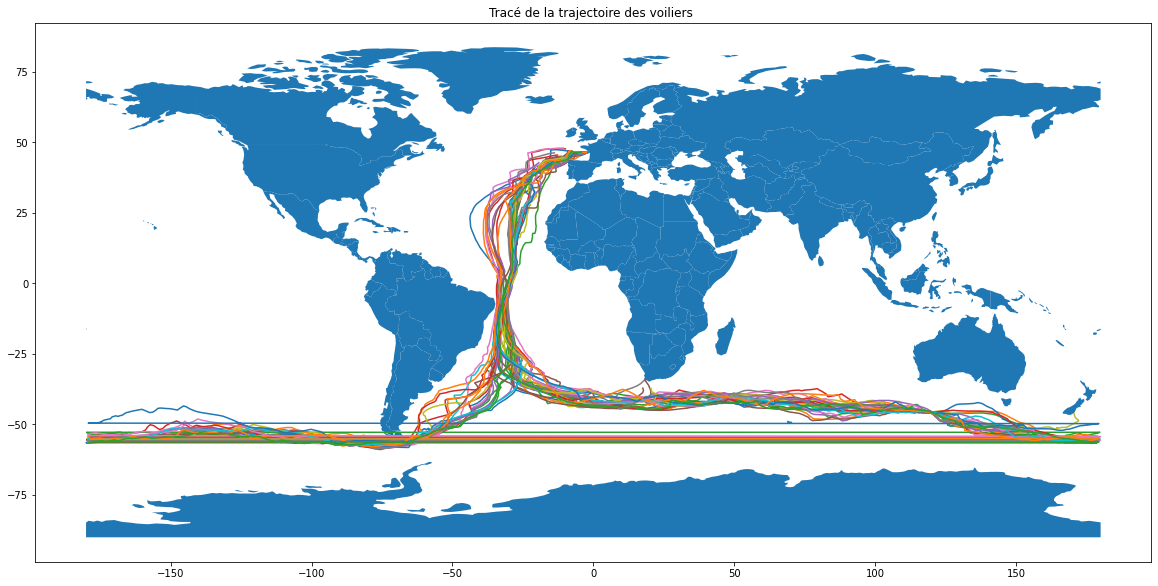

In [236]:
import geopandas

fig, ax = plt.subplots(figsize=(20, 10))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax)

# Affichage des trajectoires
for data in positions:
    plt.plot(data['longitude'], data['lattitude'])
    plt.title("Tracé de la trajectoire des voiliers ")